In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2025-11-14 14:02:27.762721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763128948.127358      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763128948.248242      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = '/kaggle/input/flickr8k/Images'
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

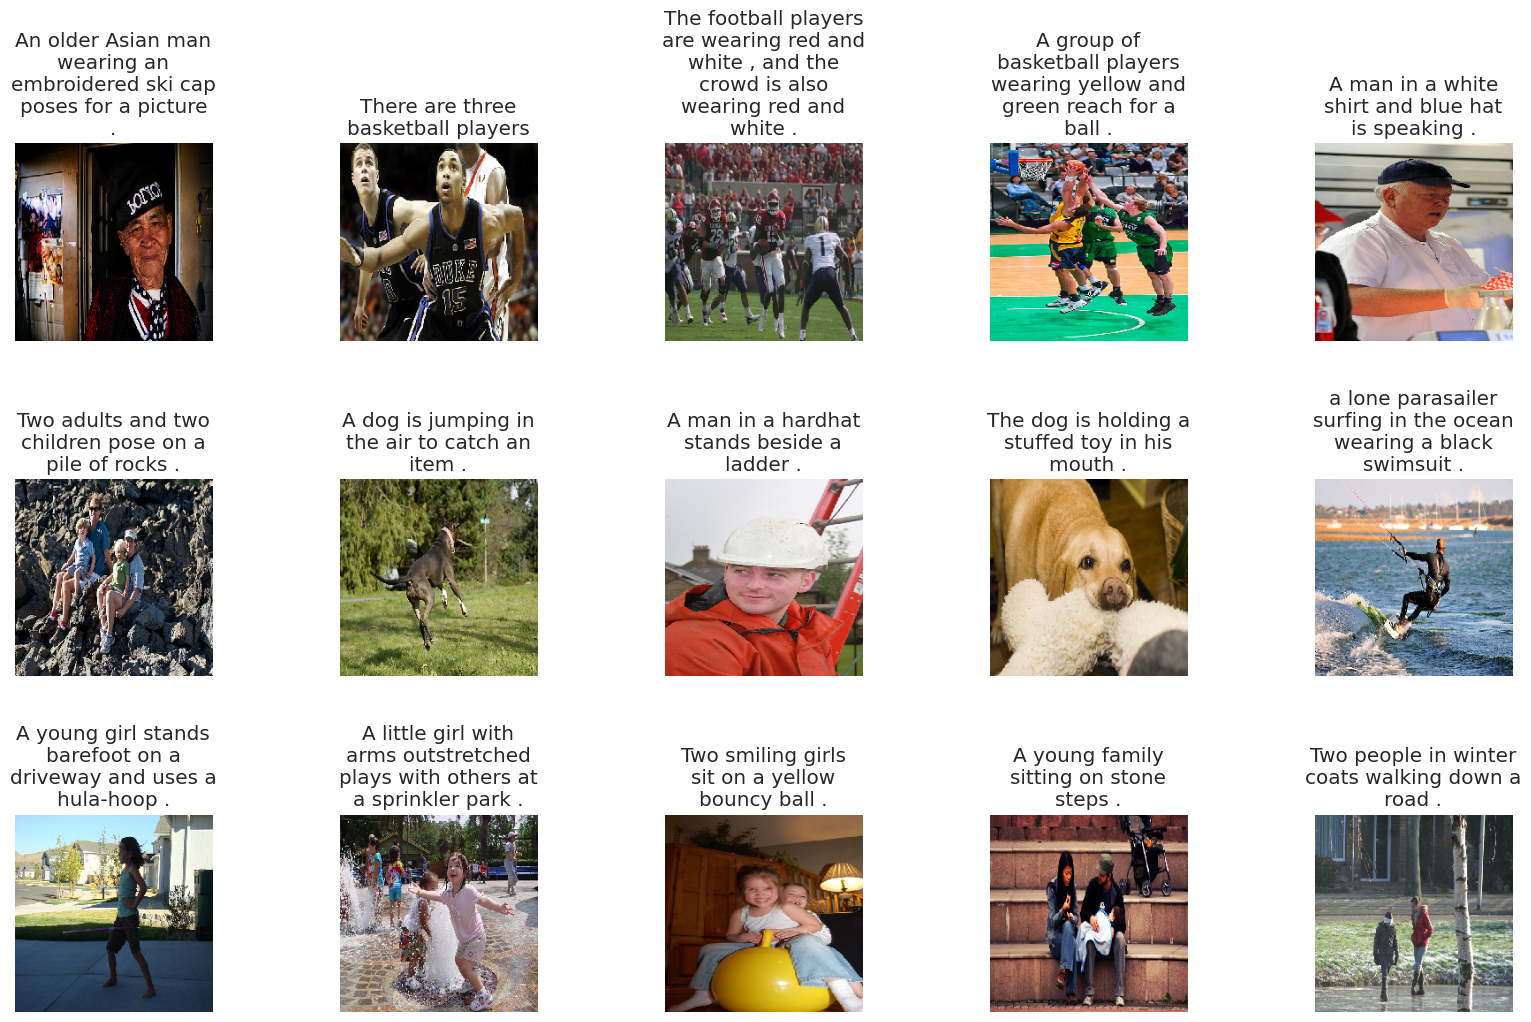

In [4]:
display_images(data.sample(15))

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [6]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[2]])[0]

[1, 39, 18, 118, 63, 195, 2428, 2]

In [8]:

model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

I0000 00:00:1763128969.002314      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763128969.003043      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1763128983.679621     103 service.cc:148] XLA service 0x7aea60004110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763128983.681571     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763128983.681594     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763128985.838841     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763128998.587712     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [14:53<00:00,  9.05it/s]


In [9]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
        
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [10]:
from tensorflow.keras.layers import RepeatVector

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)

# Correctly tile image features to match caption length
img_features_tiled = RepeatVector(max_length)(img_features)  # Shape: (None, max_length, 256)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Concatenate along the feature axis
merged = concatenate([img_features_tiled, sentence_features], axis=-1)  # Shape: (None, max_length, 512)

sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')


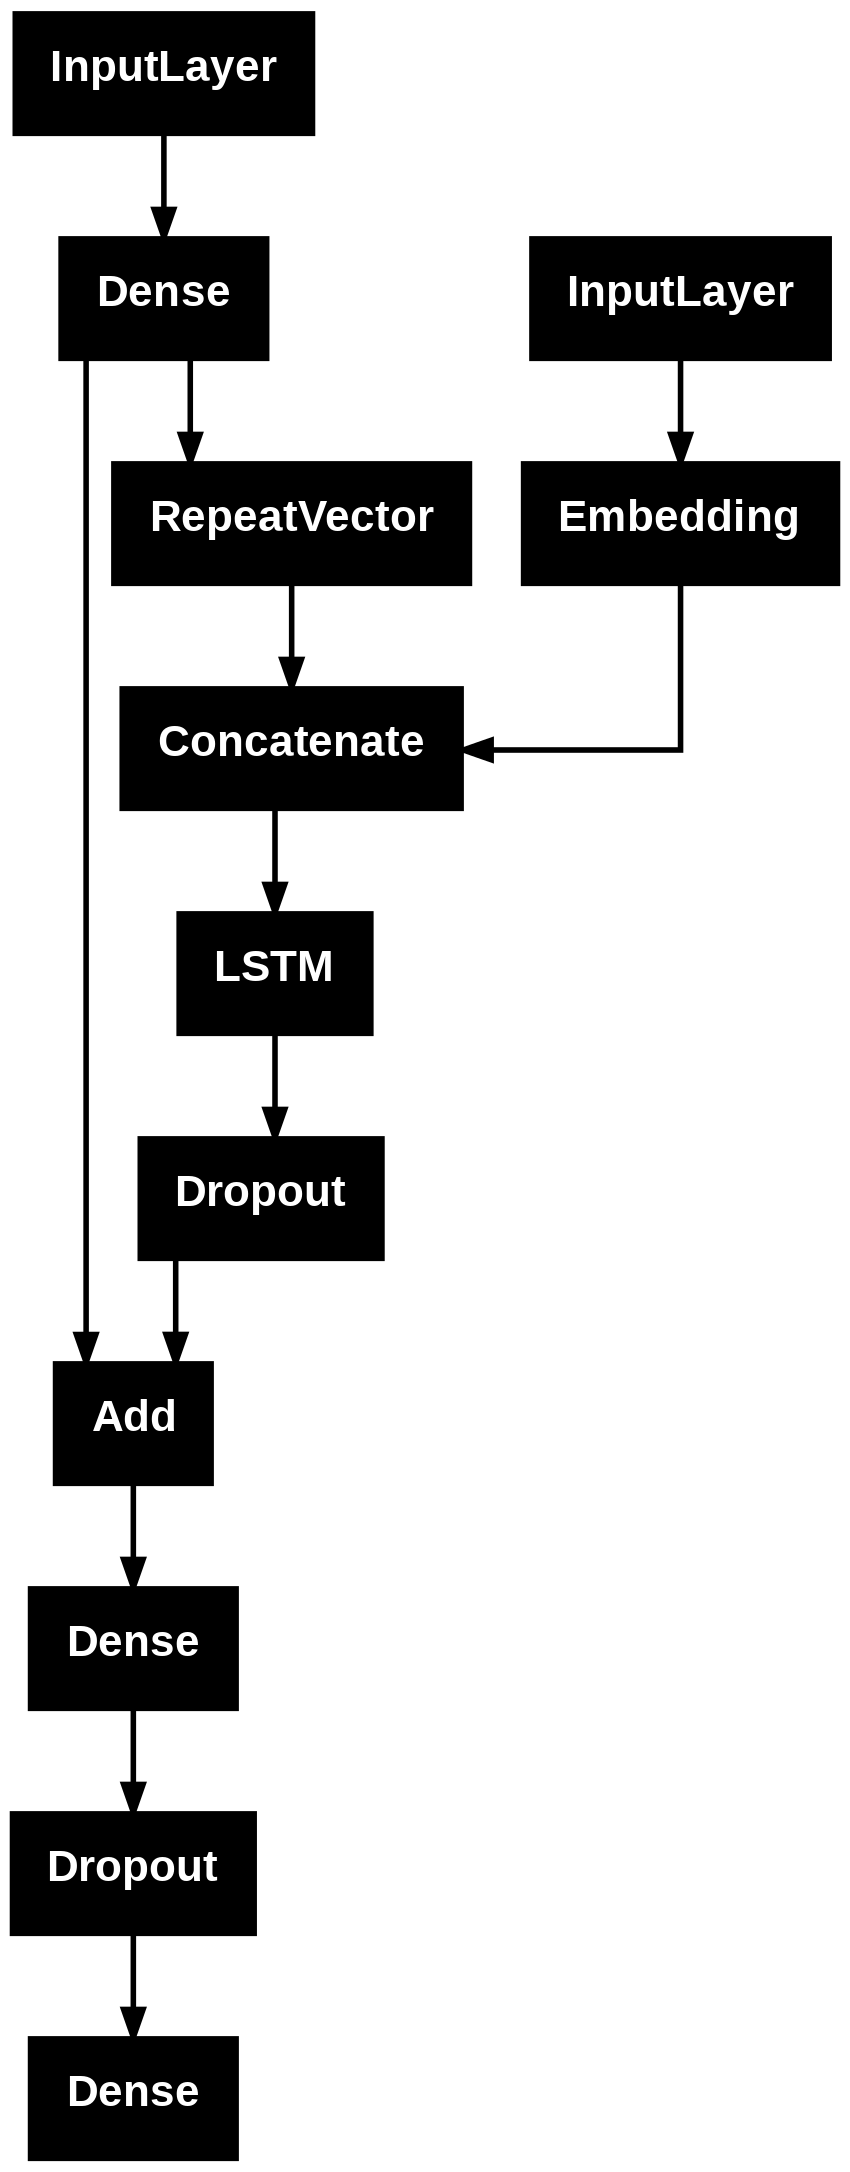

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [12]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 34, 256)   │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 34, 512)   │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    787,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,578,853 (17.47 MB)

 Trainable params: 4,578,853 (17.47 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [14]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,monitor="val_loss", mode="min", save_best_only = True, verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3,verbose=1, factor=0.2, min_lr=0.000000001)

In [15]:
history = caption_model.fit(train_generator,epochs=15,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,
                                                                                                     learning_rate_reduction])

Epoch 1/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 5.7249
Epoch 1: val_loss improved from inf to 4.30971, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - loss: 5.7237 - val_loss: 4.3097 - learning_rate: 0.0010
Epoch 2/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.3545
Epoch 2: val_loss improved from 4.30971 to 3.99129, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 4.3544 - val_loss: 3.9913 - learning_rate: 0.0010
Epoch 3/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 4.0369
Epoch 3: val_loss improved from 3.99129 to 3.81785, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 4.0369 - val_loss: 3.8179 - learning_rate: 0.0010
Epoch 4/15
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.8418
Epoch 4: val_loss improved from 3.81785 to 3.72697, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - loss: 3.8418 - val_loss: 3.7270 - learning_rate: 0.0010


In [16]:
caption_model.save('my_image_caption_model.h5')

# Optionally save your tokenizer as well
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

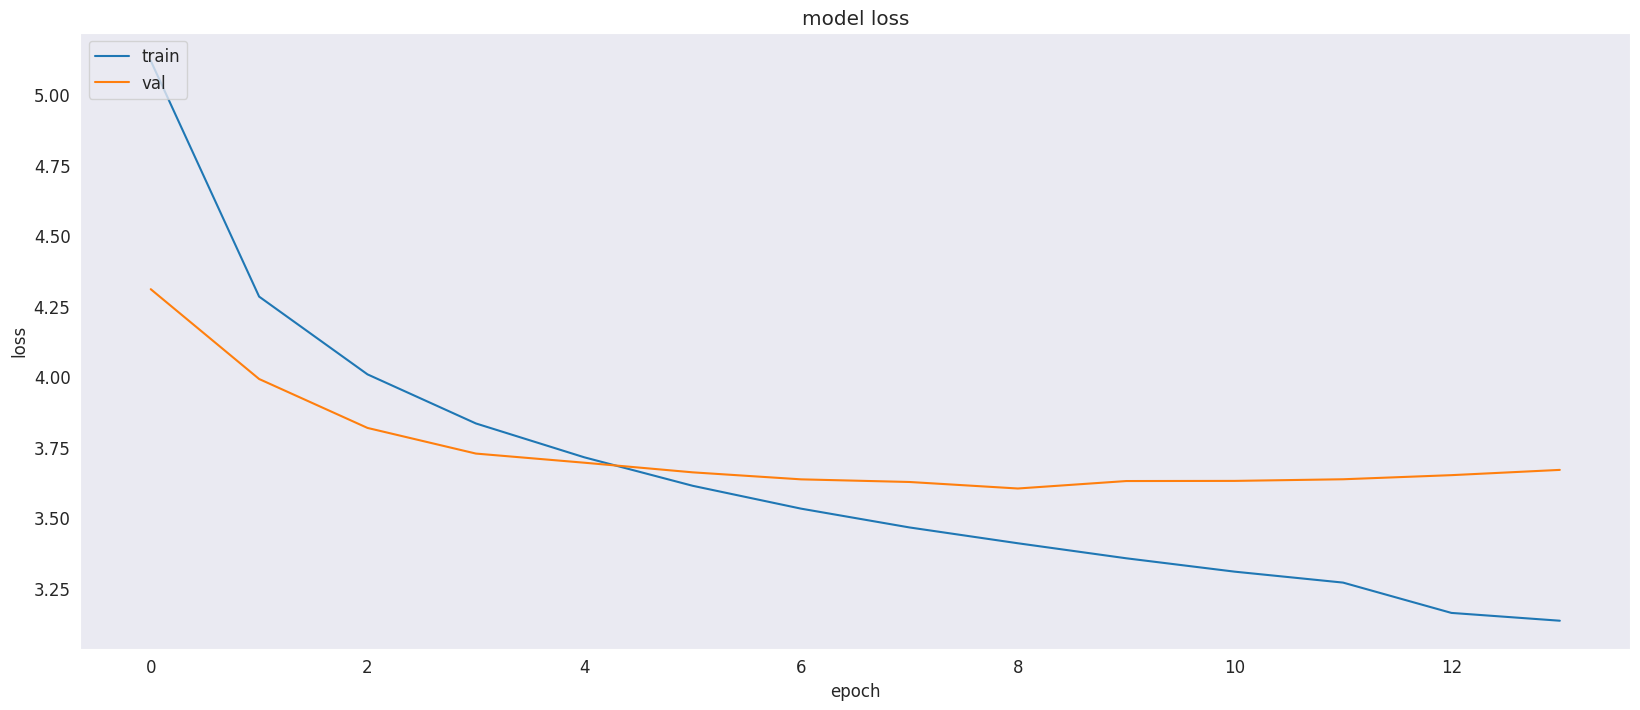

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [19]:
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [20]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [21]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

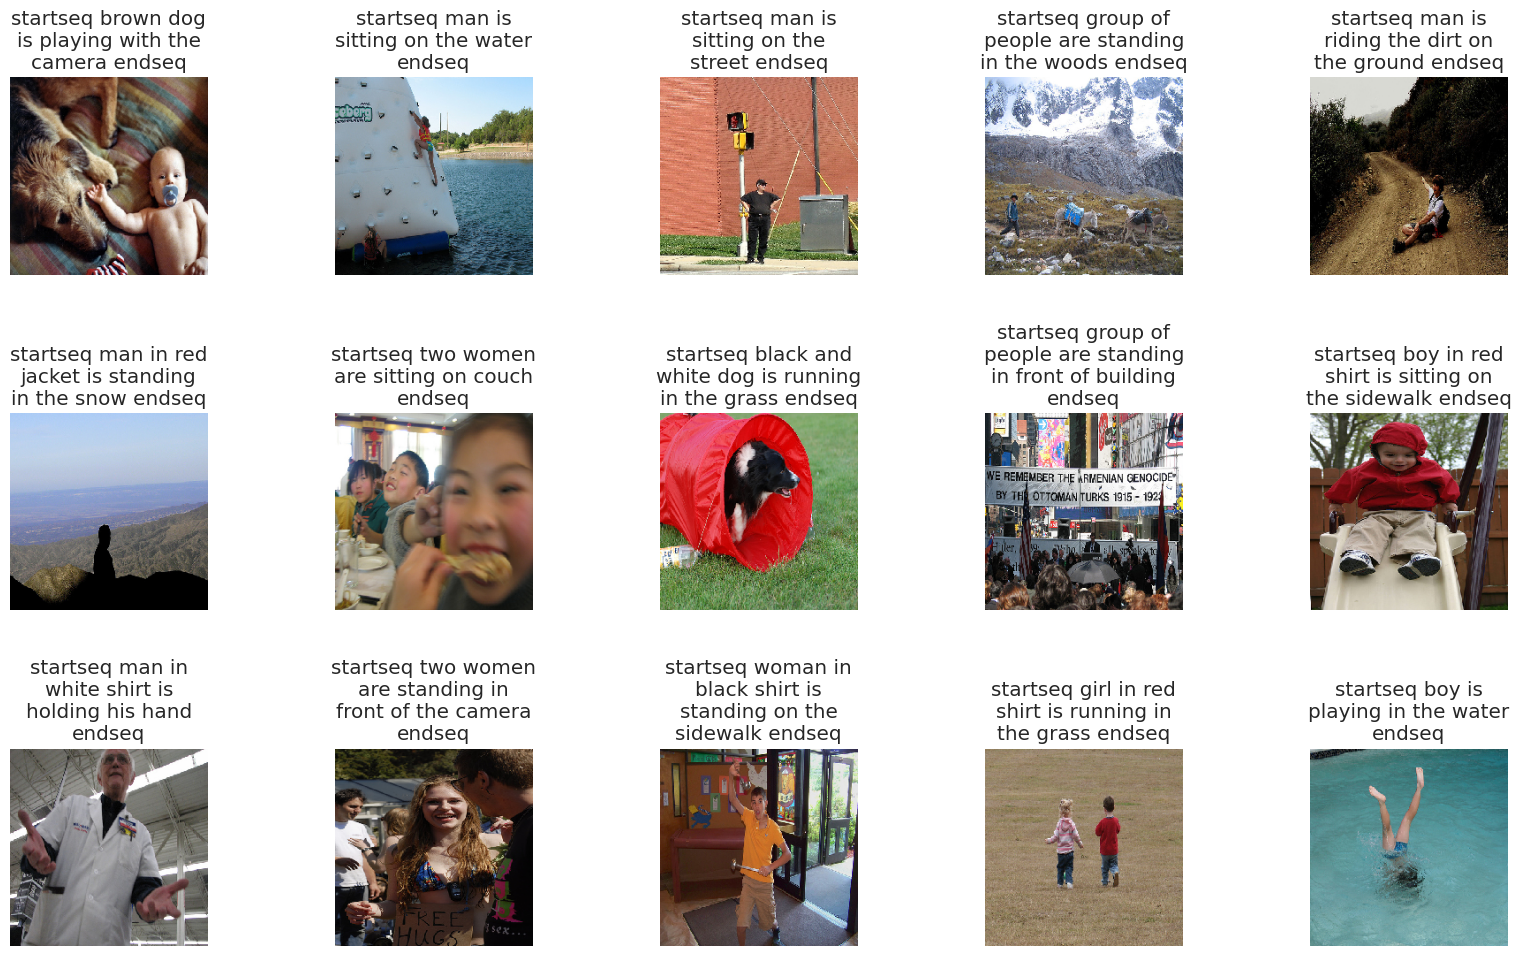

In [22]:
display_images(samples)

In [23]:
print("Vocabulary size:", len(tokenizer.word_index))
print("Max sequence length:", max_length)


Vocabulary size: 8484
Max sequence length: 34


In [ ]:
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are available
nltk.download('punkt')

# Helper function to tokenize captions
def tokenize_text(text, tokenizer=None):
    # Remove special tokens, punctuation, and tokenize
    text = text.replace('startseq', '').replace('endseq', '')
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() or word.isalnum()]
    return tokens

# Function to compute BLEU scores
def evaluate_bleu_score(model, tokenizer, features, test_data, max_length):
    print("\n🚀 Starting BLEU Score Evaluation...")
    individual_bleu_scores = []  # Store BLEU-1 scores per image
    all_references = []  # Reference captions list for corpus BLEU
    all_hypotheses = []  # Generated captions for corpus BLEU
    smoothing_function = SmoothingFunction().method1

    grouped_test_data = test_data.groupby("image")["caption"].apply(list).reset_index()
    for _, record in grouped_test_data.iterrows():
        image_name = record["image"]
        reference_captions = record["caption"]
        print(f"\n📷 Processing image: {image_name}")

        # Generate caption for this image
        generated_caption = predict_caption(model, image_name, tokenizer, max_length, features)
        print(f"🔹 Generated Caption: {generated_caption}")

        # Tokenize reference captions and generated caption
        reference_tokens = [tokenize_text(ref) for ref in reference_captions]
        generated_tokens = tokenize_text(generated_caption)

        # Only compute BLEU if both reference and generated are valid
        if not reference_tokens or not generated_tokens or len(generated_tokens) < 2:
            print(f"⚠ Skipping BLEU for {image_name} (empty or too short caption)")
            continue

        bleu1 = sentence_bleu(reference_tokens, generated_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
        bleu2 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
        bleu3 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
        bleu4 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)
        print(f"🔹 BLEU-1: {bleu1:.4f} | BLEU-2: {bleu2:.4f} | BLEU-3: {bleu3:.4f} | BLEU-4: {bleu4:.4f}")

        individual_bleu_scores.append(bleu1)
        all_references.append(reference_tokens)
        all_hypotheses.append(generated_tokens)

    # Final corpus BLEU score
    corpus_bleu_score = corpus_bleu(all_references, all_hypotheses, smoothing_function=smoothing_function)
    print(f"\n📊 BLEU Score Summary:")
    print(f"🔹 Mean BLEU Score: {np.mean(individual_bleu_scores):.4f}")
    print(f"🔹 Median BLEU Score: {np.median(individual_bleu_scores):.4f}")
    print(f"🏆 Final Corpus BLEU Score: {corpus_bleu_score:.4f}")
    return corpus_bleu_score

# Run BLEU Score Evaluation
bleu_score = evaluate_bleu_score(caption_model, tokenizer, features, test, max_length)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



🚀 Starting BLEU Score Evaluation...

📷 Processing image: 3688858505_e8afd1475d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🔹 Generated Caption: startseq two women are standing in front of the camera endseq
🔹 BLEU-1: 0.6667 | BLEU-2: 0.4082 | BLEU-3: 0.2913 | BLEU-4: 0.1411

📷 Processing image: 3689355450_fd559b816d.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🔹 Generated Caption: startseq boy is jumping on skateboard endseq
🔹 BLEU-1: 0.6000 | BLEU-2: 0.3873 | BLEU-3: 

In [26]:
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import gradio as gr
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

# -------------------------------
# BLIP model loading
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_caption_blip(img):
    raw_image = Image.fromarray(img).convert('RGB')
    inputs = processor(raw_image, return_tensors="pt")
    output_ids = blip_model.generate(**inputs, max_length=50)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption

# -------------------------------
# CNN+LSTM DenseNet201 model loading
caption_model = load_model('my_image_caption_model.h5')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
max_length = 34
feature_extractor = DenseNet201(weights='imagenet', include_top=False, pooling='avg')

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption_cnn_lstm(model, img_array, tokenizer, max_length, feature_extractor):
    try:
        img_resized = keras_image.smart_resize(img_array, (224, 224))
        if img_resized.shape[-1] == 4:
            img_resized = img_resized[..., :3]
        img_arr = np.expand_dims(img_resized, axis=0).astype('float32')
        img_arr = preprocess_input(img_arr)

        feature_vector = feature_extractor.predict(img_arr)

        in_text = "startseq"
        for _ in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            y_pred = model.predict([feature_vector, sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            word = idx_to_word(y_pred, tokenizer)
            if word is None or word == 'endseq':
                break
            in_text += " " + word

        caption = in_text.replace("startseq", "").replace("endseq", "").strip()
        return caption
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# -------------------------------
# Gradio interface function switching by selected model
def generate_caption(img, model_choice):
    if model_choice == "BLIP (Transformer-based)":
        return generate_caption_blip(img)
    else:
        return predict_caption_cnn_lstm(caption_model, img, tokenizer, max_length, feature_extractor)

# -------------------------------
# Description and CSS (unchanged)
description = """
---

**Connect with me:**  

<div style="display:inline-block; background-color:white; border-radius:8px; padding:4px; margin-right:10px; vertical-align:middle;">
  <a href="https://github.com/yakshit0511" target="_blank">
    <img src="https://cdn.jsdelivr.net/gh/devicons/devicon/icons/github/github-original.svg" width="24" />
  </a>
</div>

<div style="display:inline-block; background-color:white; border-radius:8px; padding:4px; margin-right:10px; vertical-align:middle;">
  <a href="https://www.linkedin.com/in/yakshit-koshiya-b49a11296/" target="_blank">
    <img src="https://cdn.jsdelivr.net/gh/devicons/devicon/icons/linkedin/linkedin-original.svg" width="24" />
  </a>
</div>

<div style="display:inline-block; background-color:white; border-radius:8px; padding:4px; vertical-align:middle;">
  <a href="https://myportfolio-git-main-23it047-charusatedus-projects.vercel.app/" target="_blank">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVuF7_7zPuxTuyxuFQOVjxXf0nM9QLnz_f_g&s" width="24" />
  </a>
</div>
"""

custom_css = """
body {
    background-color: #e0f7fa !important;
}
"""

# -------------------------------
# Setup Gradio interface with model choice radio input
iface = gr.Interface(
    fn=generate_caption,
    inputs=[
        gr.Image(type="numpy", label="Upload or Capture Image"),
        gr.Radio(["BLIP (Transformer-based)", "CNN+LSTM DenseNet201"], value="BLIP (Transformer-based)", label="Select Model")
    ],
    outputs="text",
    title="Image Captioning",
    description="Upload an image and select the model to generate caption.\n\n" + description,
    theme="soft"
)

# Launch app with public sharing
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://e032e0a7ca1b59c2b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
